> ### In this tutorial we will cover:
> - the basic "workflow" of building a larger molecule in biobuild

Building molecules is a straightforward task in biobuild. It involves always the same steps:

```mermaid

flowchart TB
  node_1["identify suitable sub-structure A"]
  node_2["identify suitable sub-structure B"]
  node_3["identify what you want to build"]
  node_4["identify atom to connect to B"]
  node_5["identify atom to connect to A"]
  node_6["identify atom(s) to\nremove when connecting to B"]
  node_7["identify atom(s) to\nremove when connecting to A"]
  node_8(("connect"))
  node_9("repeat")
  node_3 --> node_1
  node_3 --> node_2
  node_1 --> node_4
  node_2 --> node_5
  node_1 --> node_6
  node_2 --> node_7
  node_6 ---> node_8
  node_4 ---> node_8
  node_5 --> node_8
  node_7 --> node_8
  node_8 --> node_9

```

As for steps 1 and 2, finding a structure to build and identifying subcomponents - that's on you, biobuild cannot help you there! As for steps 3 and 4, thats where biobuild can start to help you. How do you identify which atoms to connect and which to remove? Well, by looking at the structures, of course! 

If biobuild has a linkage already defined for your specific task, great! But most of the time we want to build custom molecules for which the CHARMM force field does not conveniently have a patch defined. So we need to define the linkage ourselves. We can do this by looking at the structure, checking out what the atoms we want to connect are called, and then define our linkage. We can either connect molecules using the `Molecule.attach` method where we can directly provide the information regarding atoms-to-connect and -remove, or we first set up a `Linkage` which can then use instead. 

The advantage of setting up a `Linkage` first is that we can then re-use the same linkage time and time again, without needing to keep filling in the information manually. We can even add custom linkages to the default settings to make them permanently available whenever we use biobuild (checkout the tutorials regarding built-in resources and setting defaults). 

Working by example is usually best, so let us build the following molecule:

![image.png](files/mol1_black.png)

We can start by identifying the different components that we might want to work with. For example we can choose these:

![](files/mol1_color.png)

With our components decided, we can start to build. The first step is getting the molecular structures we need. PubChem is sure to have the structures available, so we are not going to load any built-in structures.

In [1]:
import biobuild as bb

# get the molecules we need
phenyl_methanol = bb.molecule("phenylmethanol")
aldehyde = bb.molecule("butyraldehyde")
amine = bb.molecule("methoxyethanamine")
naphthalene = bb.molecule("1,2,4a,8a-tetrahydronaphthalene")

# because PubChem structures use a simple enumeration rather than hierarchical atom labelling
# we can (optionally) call `autolabel` to assign more descriptive atom labels which is useful for 
# defining linkages
phenyl_methanol.autolabel()
aldehyde.autolabel()
amine.autolabel()
naphthalene.autolabel() 

Now that our molecules are all ready, we can start building. We start by attaching the `phenyl_methanol` to the `aldehyde`. To do this, we first visualize both structures to identify the `atom ids` of the atoms we want to connect and remove in both cases.

In [2]:
# visulize the methanol
phenyl_methanol.show()

From the inspection we can tell that the Oxygen is called `O7`, it is connected to `C7` and `HO7`. `C7` has two hydrogens called `H71` and `H72`. That's all we needed to know at this point. Next up is the aldehyde:

In [3]:
aldehyde.show()

We can tell that the tail carbon is called `C4` with its hydrogen atoms `H41`, `H42`, `H43`. The carbon before that was called `C3` and it had hydrogens `H31` and `H32`.  In fact, the labelling is quite intuitive, and that's thanks to `autolabel`. It uses a hierarchical ranking scheme to determine atom labels, starting with the highest ranked carbon and then iteratively labelling lesser carbons and hetero atoms. As a rule of thumb, start with the most connected carbon in a circular structure, that's `C1`, then try forming the longest possible chain of consequtive carbons. If you reach a dead-end find the next most connected carbon again and continue from there. Using this scheme, you won't even need to look at small structures like these to know their atom labelling.

Equipped with this information we can attach the aldehyde to the methanol like so:

In [4]:
# define a linkage for use with bb.connect
link1 = bb.linkage(atom1="C7", # the atom in phenyl_methanol to connect
                   atom2="C3", # the atom in aldehyde to connect
                   delete_in_target=["H71"], # the atom in phenyl_methanol to delete
                   delete_in_source=["H32"] # the atom in aldehyde to delete
                   )

# now connect the molecules
mol = bb.connect(phenyl_methanol, aldehyde, link1)

# visualize the result
mol.show()

Now we can go about attaching a second phenyl-methanol to the structure. This time by connecting it's oxygen `O7` to the `C1` of the aldehyde. We will use the method-syntax `Molecule.attach` this time, as opposed to the function `connect`. 

In [5]:
# make a second linkage
link2 = bb.linkage(atom1="C1", # the atom in our composite molecule to connect
                   atom2="O7", # the atom in the incoming phenyl_methanol to connect
                   delete_in_target=["H1"], # the atom in our composite molecule to delete
                   delete_in_source=["HO7"], # the atom in the incoming phenyl_methanol to delete
)
# connect a second phenyl-methanol
mol.attach(phenyl_methanol, link2)

# visualize the result
mol.show()

Now it's time for the amine to join the show. We can savely predict that the highest connected carbon is the one between the nitrogen and oxygen, so we can predict that the N will be called `N1` and the O `O1`. But let's look at the structure all the same to be sure:

In [6]:
amine.show()

Phew, lucky we checked the structure. The oxygen was called `O3` because hetero atoms are labelled by the highest labelled neighbor. Nevertheless, we learned the next connection will need to be between `N1` in the amine and `C7` of the second phenyl-methanol in the molecule we are building.

Since we are building "from one end to the other" we do not need to bother with speciying in which residue to search for the atoms to connect, because biobuild will by default use the latest residue for attaching new molecules. However, if we do find ourselves working with branched structures, we can always use the  `at_residue` and `other_residue` arguments to specify which residues to use when attaching different molecules.

In [7]:
# connect the amine to the molecule
# by now we understand these parameters
link3 = bb.linkage("C7", "N1", ["H71"], ["HN11"])

# attach and visualize
mol.attach(amine, link3)
mol.show()

Almost there, the only thing left is the naphthalene. We know the drill by now, so let's just quickly visualize to find out what the carbon we want to connect is called.

In [8]:
naphthalene.show()

With the information that we are looking for `C6` and its hydrogens, we can finish our structure:

In [9]:
link4 = bb.linkage("C3", "C6", ["H32"], ["H62"])

# attach (using another whacky syntax) and visualize
final = mol % link4 + naphthalene
final.show()

Alrighty, that is the structure we just built! Admitedly, it looks a bit crammed. So, let's optimize the conformation a little. Optimizing conformations in biobuild is a topic all to its own, so go check out the tutorial on optimizing structures for a better introduction. Here is just some code that will optimize the little molecule we have:

In [20]:
from biobuild import optimizers

graph = final.make_atom_graph()

edges = graph.find_rotatable_edges(min_descendants=5, min_ancestors=5)

env = optimizers.DistanceRotatron(graph, edges, radius=10)

final_optimized = bb.optimizers.optimize(final.copy(), env)
final_optimized.show()

That one looks a little better. Of course, since the structure is quite dense, there is a limit as to what we can achieve, but we can check if we have any clashes left in our final structure using:

In [23]:
print("clashes before:", final.find_clashes())
print("clashes after:", final_optimized.find_clashes())

clashes before: [(Atom(C1, 20), Atom(H21, 47))]
clashes after: []


With that out of the way, we can think of what to do next with our molecule. Perhaps our project involves molecular docking simulations that require a PDB input. We can easily export our new molecule using the `to_pdb` method or the `write_pdb` function:

In [24]:
bb.write_pdb(final_optimized, "final_optimized.pdb")

By the way, if we would like to see our molecule in 2D again, we can simply export it to `rdkit`, which has a native 2D rendering support:

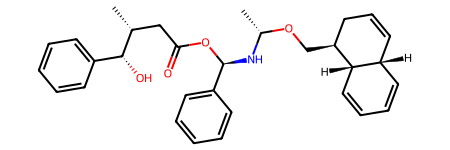

In [25]:
# export to rdkit
rd_mol = final_optimized.to_rdkit()

# remove the 3d coordinates
rd_mol.RemoveAllConformers()

# show the image (automatically in a jupyter notebook)
rd_mol

With that we have reached the end of this little walkthrough to the basic work-routine of building structures in biobuild. As you hopefully agree, it is quite straightforward to use biobuild to create larger structures from small components. Of course, even though we have only used single-residue components in this tutorial, there is (in principle) no limit to what biobuild can connect. It becomes especially useful if you build parts of a molecule separately and then simply join them together. With that, good luck in your project using biobuild!